In [63]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import json

The simulation will take place between start_day and end_day. covasim can not support simulations longer thanb 150 days

In [2]:
start_day = '2020-03-02'
end_day   = '2020-07-01'
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

We use Gerlee et al. to have a moving beta according to the data from the traffic. 

In [3]:
# defining a moving beta accoding to the article predicting regional covid 19 hospital admissions in Sweden using mobility data

mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']
betas = [ 4.11 + 6.68 * mob for mob in floatmobility]
betas_by_week=np.array([betas[i//7] for i in range(len(all_days))])
# coeff_betas=[betas_by_week[i+1]/betas_by_week[i] for i in range(len(betas_by_week)-1)]
coeff_betas=[betas_by_week[i]/beta_initial for i in range(len(betas_by_week))]


The values of beta seem very high compared to the previsous values found in litrerature. 


Creating parameters that fit the Swedish population

In [4]:
parameters_sweden=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=beta_initial,  
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )




In [5]:
# interventions of changing beta: we create a cv.change_beta object that changes beta everyday according to the values of the traffic circulation. 
cb_mobility = cv.change_beta(days=all_days, changes=coeff_betas, do_plot=False) # warning, change_beta does not change the value of beta, it multiplies the value of beta_0 by a constant and replaces the previois beta by this new one. 


In [6]:
# set run_simul = True to run the simulation and create data : 
run_simul=False
if run_simul: 
    my_simulation_sweden_interventions=cv.Sim(parameters_sweden, interventions=cb_mobility)
    my_simulation_sweden_interventions.run()
    my_simulation_sweden_interventions.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


We have stored in a csv file the synthetized data and extract it as a baseline: 

In [7]:
df = pd.read_csv('deaths_and_infections.csv')
# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)

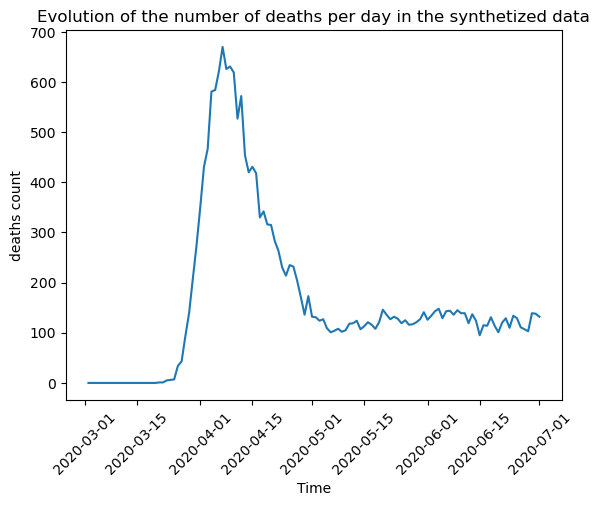

In [8]:
plt.plot(date_range, df['new_deaths'], label='new_deaths')
plt.title('Evolution of the number of deaths per day in the synthetized data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('deaths count')

plt.show()

In [9]:
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

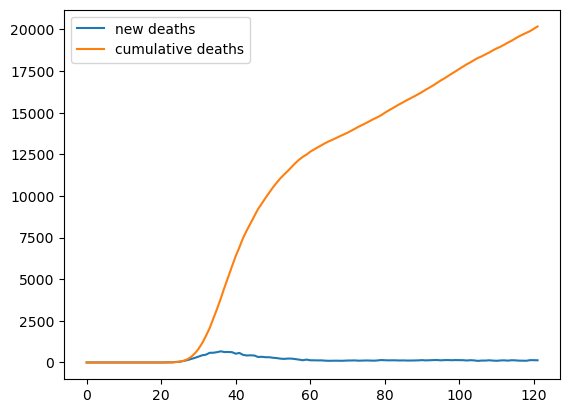

In [10]:
plt.plot(dates_of_pandemic,new_deaths, label='new deaths')
plt.plot(dates_of_pandemic,death_cumul, label='cumulative deaths')
plt.legend()
plt.show()

We try to fit some simple models

In [11]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [12]:
def polynomla_func(x, a, b, c, d, e , f):
    return a*x**2+b*x+c + e*x**3 

In [13]:
p, _ =curve_fit(exponential_func, dates_of_pandemic, new_deaths)
p
p2, _ =curve_fit(polynomla_func, dates_of_pandemic, new_deaths)


c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


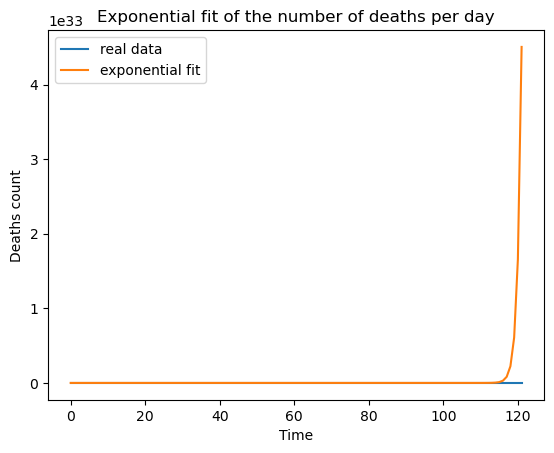

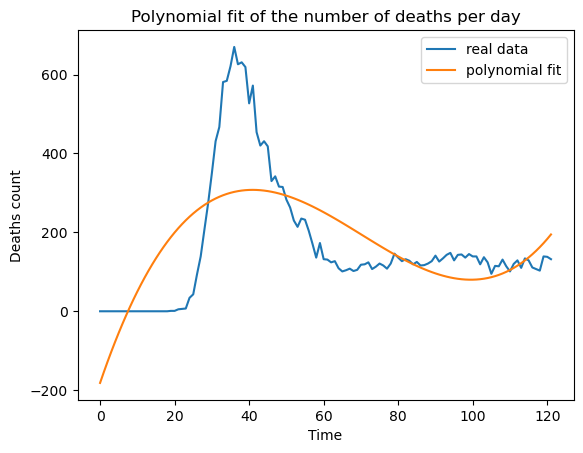

In [14]:
plt.plot(dates_of_pandemic,new_deaths, label='real data')
plt.plot(dates_of_pandemic, exponential_func(dates_of_pandemic, *p), label= 'exponential fit')
plt.title('Exponential fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()

plt.plot(dates_of_pandemic,new_deaths,  label='real data')
plt.plot(dates_of_pandemic, polynomla_func(dates_of_pandemic, *p2), label= 'polynomial fit')
plt.title('Polynomial fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()




We now implement our own SIR model

In [15]:
def derive(x, beta, N, gamma, d):
    s=x[0]
    i=x[1]
    r=x[2]
    deads=x[3]
    return np.array([-beta*s*i/N, beta*s*i/N - gamma*i - d * i , gamma*i , d * i ])


In [16]:
def run_sir(x0, beta, gamma,d,  t, dt):
    x=x0
    S=[x[0]]
    I=[x[1]]
    R=[x[2]]
    D=[x[3]] # deads 
    n_iter=int(t/dt)
    N=sum(x0)
    for i in range(n_iter):
        x=x+dt*derive(x, beta, N, gamma, d)
        S.append(x[0])
        I.append(x[1])
        R.append(x[2])
        D.append(x[3])
    s_final=[]
    i_final=[]
    r_final=[]
    d_final=[]
    time=np.linspace(0, t, int(t/dt) )
    for i in range(len(time)-1):
        if abs(time[i]-int(time[i]))<dt: 
            s_final.append(S[i])
            i_final.append(I[i])
            r_final.append(R[i])
            d_final.append(D[i])
    return s_final, i_final, r_final, d_final
    



We run an exeample of SIR with same population size as in the Swedish model: 

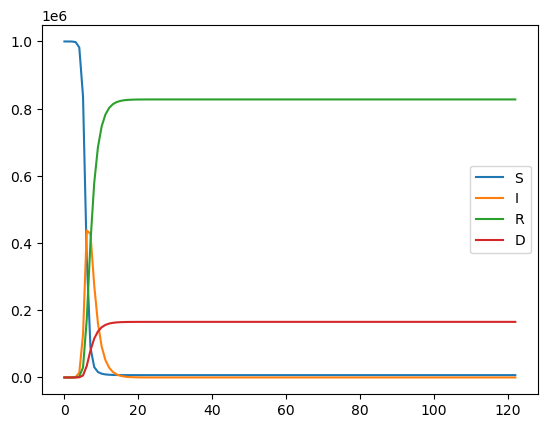

In [17]:
s_0=1000000 -1
i_0=1
r_0=0
d_0=0
beta=3
gamma=0.5
d=0.1
t=len(death_cumul-1)
dt=0.001
%matplotlib inline
S, I, R , D= run_sir([s_0, i_0, r_0, d_0], beta, gamma,d, t, dt)
time=np.linspace(0, t, t)
plt.plot(time, S,  label='S')
plt.plot(time, I, label='I')
plt.plot(time,R, label='R')
plt.plot(time, D, label='D')
plt.legend()
plt.show()

We need to update the SIR to plug it into the curve_fit function

In [20]:
def differenciate(x): 
    dx=[x[i+1]-x[i] for i in range(len(x)-1)]
    return dx


In [21]:

#def run_sir(x0, beta, gamma,d,  t, dt):


def sir_for_optim(x, beta, gamma, d):
    # x is a list of dates (0 - 122)
    x0=[s_0, i_0, r_0, d_0]
    t=len(x-1)
    S,I,R,D=run_sir(x0, beta, gamma,d,  t, dt)
    zer=np.array([0])
    d_arr=np.array(D)
    return differenciate(np.concatenate((zer,d_arr)))

Optimization: 

In [61]:
# set run_optim = True to run the optim
run_optim = False
if run_optim: 
    p, _= curve_fit(sir_for_optim, dates_of_pandemic,new_deaths, p0=(3,0.5,0.1),  bounds=([0,0,0], [np.inf,np.inf,np.inf]))

# results computed previously: 
    

p=np.array([ 15.84445325, -14.84483028,  30.61694214])


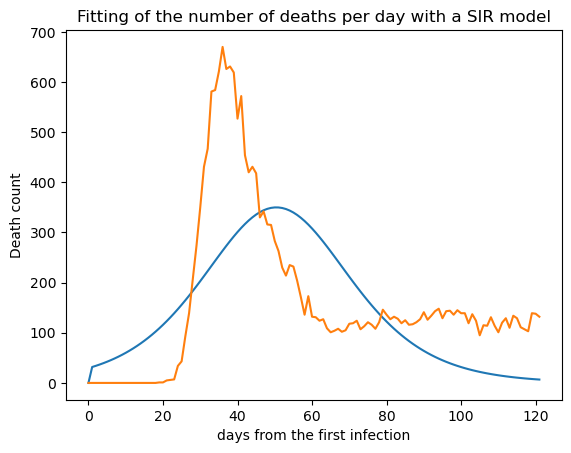

In [62]:
plt.plot(sir_for_optim(dates_of_pandemic, *p))
plt.plot(new_deaths)
plt.xlabel('days from the first infection')
plt.ylabel('Death count')
plt.title('Fitting of the number of deaths per day with a SIR model')
plt.show()

Optimization does not seem to work as the loss function is not explicitely differentiable, let's try a grid search : 

In [79]:
betas=np.arange(0, 31, 0.5)
gammas=np.arange(0,31, 0.5)
ds=np.arange(0, 31, 0.5)
min=np.sum(np.abs(sir_for_optim(dates_of_pandemic,  0.5, 0.6, 0.3) - new_deaths))
print(min)
dicoresults=dict()
gammamin=0
betamin=0
dmin=0

for beta in betas: 
    for gamma in gammas: 
        for d in ds:
            error = np.sum(np.abs(sir_for_optim(dates_of_pandemic, beta, gamma, d) - new_deaths))
            if error<min: 
                min=error
                gammamin=gamma
                betamin=beta
                dmin=d
                print('new min found')
                print(min)
                print('the values are : ')
                print('beta = ', beta)
                print('gamma = ', gamma)
                print('d = ', d)
            dicoresults['beta = '+ str(beta) + ' gamma = '+ str(gamma) + ' d = '+ str(d)]=min
            

with open('results.json', 'w') as f:
    json.dump(dicoresults, f)
print('saved')

20309.748880233918
new min found
20309.0
the values are : 
beta =  0.0
gamma =  0.0
d =  0.0
new min found
20266.53838291002
the values are : 
beta =  0.5
gamma =  0.0
d =  0.5
saved


In [80]:
# lodad results
with open('results.json', 'r') as f:
    results=json.load(f)
print(results)


{'beta = 0.0 gamma = 0.0 d = 0.0': 20309.0, 'beta = 0.0 gamma = 0.0 d = 0.5': 20309.0, 'beta = 0.0 gamma = 0.5 d = 0.0': 20309.0, 'beta = 0.0 gamma = 0.5 d = 0.5': 20309.0, 'beta = 0.5 gamma = 0.0 d = 0.0': 20309.0, 'beta = 0.5 gamma = 0.0 d = 0.5': 20266.53838291002, 'beta = 0.5 gamma = 0.5 d = 0.0': 20266.53838291002, 'beta = 0.5 gamma = 0.5 d = 0.5': 20266.53838291002}


We faced difficulties to understand the real role of change_beta, the test are here to explain it

Initializing sim with 10000 people for 121 days
Loading location-specific data for "Sweden"Initializing sim with 10000 people for 121 days

Loading location-specific data for "Sweden"
  Running "intervention": 2020-03-02 ( 0/121) (0.10 s)  ———————————————————— 1%
  Running "no intervention": 2020-03-02 ( 0/121) (0.10 s)  ———————————————————— 1%
  Running "intervention": 2020-03-12 (10/121) (0.12 s)  •——————————————————— 9%
  Running "no intervention": 2020-03-12 (10/121) (0.12 s)  •——————————————————— 9%
  Running "no intervention": 2020-03-22 (20/121) (0.15 s)  •••————————————————— 17%

  Running "intervention": 2020-04-01 (30/121) (0.18 s)  •••••——————————————— 25%
  Running "no intervention": 2020-04-01 (30/121) (0.18 s)  •••••——————————————— 25%
  Running "no intervention": 2020-04-11 (40/121) (0.22 s)  ••••••—————————————— 34%

  Running "intervention": 2020-04-21 (50/121) (0.27 s)  ••••••••———————————— 42%42%

  Running "intervention": 2020-05-01 (60/121) (0.32 s)  ••••••••••————

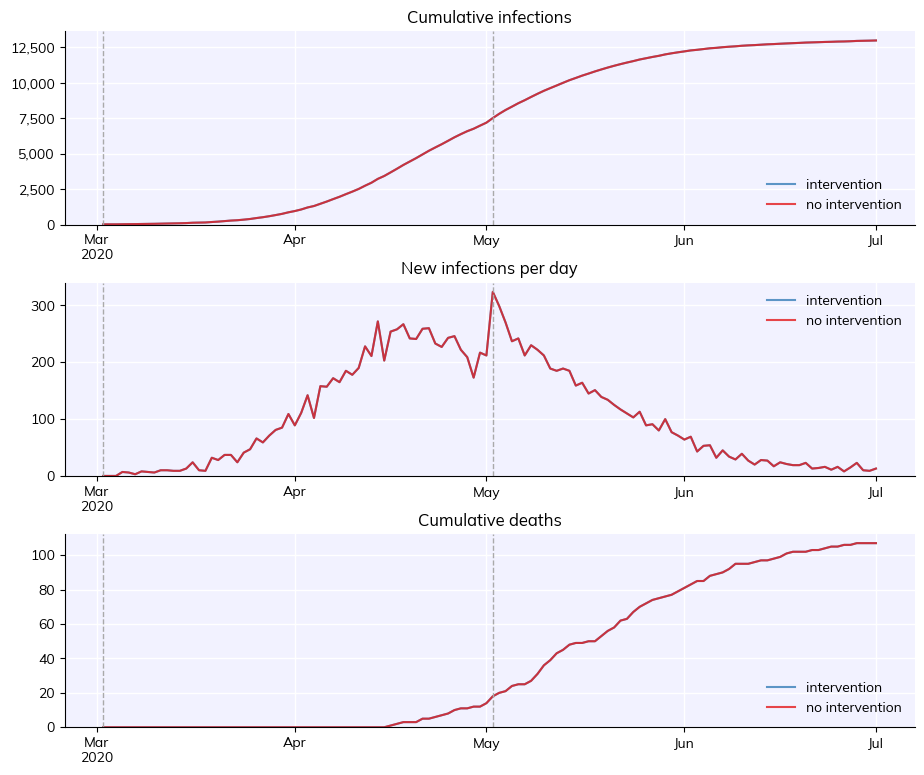

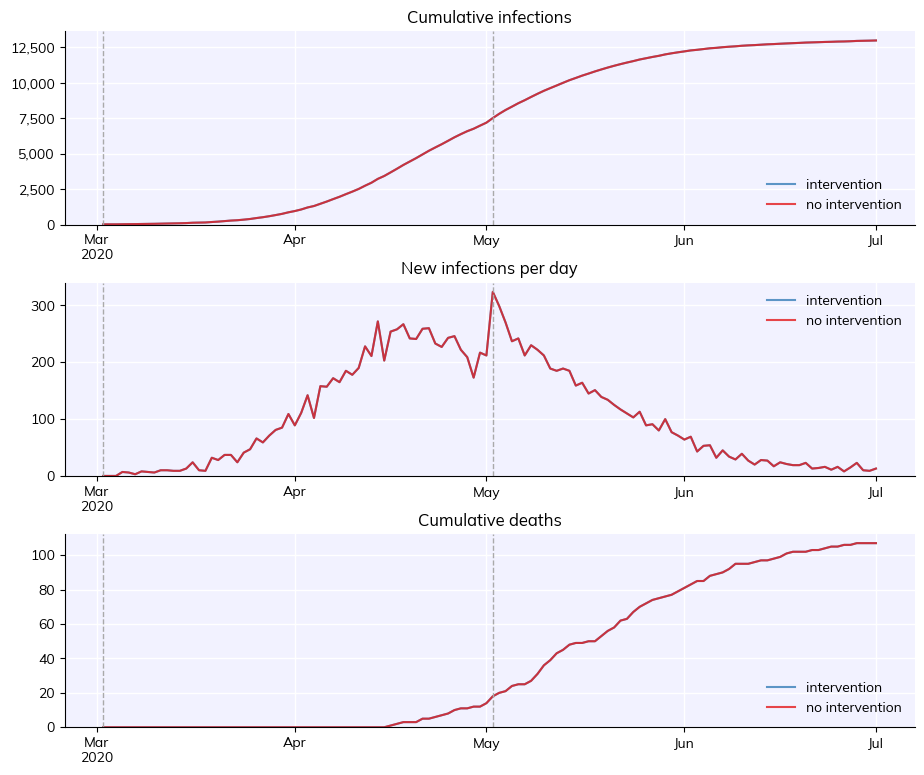

In [46]:
# THIS CELLE ENABLES TO CHECK WHAT change_beta REALLY DOES






param1=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=0.015,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )


param2=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=1,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )




cb1=cv.change_beta(days=['2020-03-02',  '2020-05-02',  ], changes=[1, 2], do_plot=True)
cb2=cv.change_beta(days=['2020-03-02',  '2020-05-02',  ], changes=[0.015, 0.03], do_plot=True)

sim1=cv.Sim(param1, interventions=cb1, label='intervention')
sim2=cv.Sim(param2, interventions=cb2, label='no intervention')
msim=cv.MultiSim([sim1, sim2])
msim.run()
msim.plot()

